# Libraries

In [24]:
import random
import ray
import tensorflow as tf
import utils
from gym import spaces
from ray.rllib.algorithms.dqn.distributional_q_tf_model import DistributionalQTFModel
from ray.rllib.algorithms.dqn.dqn import DQN
from ray.rllib.models import ModelCatalog
from ray.rllib.utils.typing import ModelConfigDict, TensorType
from environments.cartpole import CartPoleEnv

# Custom Model

In [25]:
class DQNCustomModel(DistributionalQTFModel):
    def __init__(
            self,
            obs_space: spaces.Space,
            action_space: spaces.Space,
            num_outputs: int,
            model_config: ModelConfigDict,
            name: str,
            q_hiddens=(256,),
            dueling=True,
            num_atoms=51,
            v_min=-1.0,
            v_max=1.0,
            use_noisy=True,
            sigma0=0.5,
            add_layer_norm=True,
            verbose=True
    ):
        super().__init__(
            obs_space,
            action_space,
            num_outputs,
            model_config,
            name,
            q_hiddens=q_hiddens,
            dueling=dueling,
            num_atoms=num_atoms,
            v_min=v_min,
            v_max=v_max,
            use_noisy=use_noisy,
            sigma0=sigma0,
            add_layer_norm=add_layer_norm
        )

        self.base_model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=obs_space.shape, name='observations'),
            tf.keras.layers.Dense(units=256, activation='tanh', name='hidden'),
            tf.keras.layers.Dense(units=num_outputs, activation='tanh', name='outputs')
        ], name='base_model')

        if verbose:
            print('--- Value Network ---')
            self.state_value_head.summary(expand_nested=True)

            print('--- Q Network ---')
            self.q_value_head.summary(expand_nested=True)

    def forward(self, input_dict: dict[str, TensorType], state: list[TensorType], seq_lens: TensorType) -> (TensorType, list[TensorType]):
        model_out = self.base_model(input_dict['obs'])
        return model_out, state

# Default Model Train

2022-12-31 22:03:51,510	INFO worker.py:1518 -- Started a local Ray instance.
2022-12-31 22:03:52,906	WARNING deprecation.py:47 -- DeprecationWarning: `config['learning_starts']` has been deprecated. config['replay_buffer_config']['learning_starts'] This will raise an error in the future!
2022-12-31 22:03:52,907	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
2022-12-31 22:03:53,161	WARNING util.py:65 -- Install gputil for GPU system monitoring.


Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 observations (InputLayer)      [(None, 4)]          0           []                               
                                                                                                  
 fc_1 (Dense)                   (None, 256)          1280        ['observations[0][0]']           
                                                                                                  
 fc_out (Dense)                 (None, 256)          65792       ['fc_1[0][0]']                   
                                                                                                  
 value_out (Dense)              (None, 1)            257         ['fc_1[0][0]']                   
                                                                                           

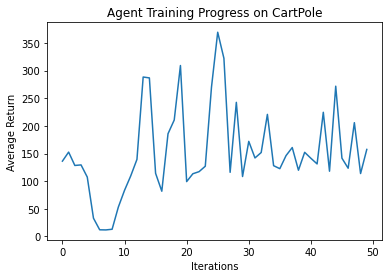

[136.2,
 152.6,
 128.4,
 129.4,
 107.4,
 33.0,
 12.0,
 11.8,
 13.0,
 53.0,
 83.4,
 109.6,
 139.4,
 288.4,
 286.8,
 114.2,
 81.8,
 185.8,
 210.6,
 309.2,
 99.2,
 113.4,
 117.2,
 127.0,
 270.2,
 369.4,
 322.2,
 116.0,
 242.6,
 108.4,
 172.0,
 142.0,
 151.8,
 220.8,
 128.0,
 122.6,
 146.2,
 160.8,
 119.8,
 152.2,
 141.4,
 131.2,
 224.6,
 118.0,
 271.8,
 141.6,
 123.4,
 205.8,
 113.8,
 157.4]

In [26]:
ray.shutdown()
ray.init()
tf.random.set_seed(seed=0)
random.seed(0)
agent = DQN(env=CartPoleEnv, config={
    'env_config': {'verbose': False},
    'replay_buffer_config' : {
        "type": 'MultiAgentPrioritizedReplayBuffer',
        "capacity": 50000,
        'prioritized_replay': True,
        'prioritized_replay_alpha': 0.6,
        'prioritized_replay_beta': 0.4,
        'prioritized_replay_eps': 1e-6,
        'replay_sequence_length': 1,
    },
    'num_steps_sampled_before_learning_starts': 5000,
    'target_network_update_freq': 2500,
    'rollout_fragment_length': 4,
    'train_batch_size': 64,
    'n_step': 3,
    'double_q': True,
    'dueling': True,
    'noisy': True,
    'num_atoms': 51,
    'v_min': -500.0,
    'v_max': 500.0,
    'exploration_config': {
        'epsilon_timesteps': 2,
        'final_epsilon': 0.0
    },
    'seed': 0,
    'gamma': 0.99,
    'lr': 0.001,
    'num_gpus': 1
})
agent.get_policy().model.base_model.summary(expand_nested=True)
utils.train(agent=agent, eval_env=CartPoleEnv(env_config={'verbose': False}))

#  Custom Model Train

2022-12-31 22:42:22,101	INFO worker.py:1518 -- Started a local Ray instance.
2022-12-31 22:42:29,115	WARNING deprecation.py:47 -- DeprecationWarning: `config['learning_starts']` has been deprecated. config['replay_buffer_config']['learning_starts'] This will raise an error in the future!
2022-12-31 22:42:29,116	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!


--- Value Network ---
Model: "model_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_out (InputLayer)      [(None, 256)]             0         
                                                                 
 noisy_layer_66 (NoisyLayer)  (None, 256)              131584    
                                                                 
 noisy_layer_67 (NoisyLayer)  (None, 51)               26214     
                                                                 
Total params: 157,798
Trainable params: 157,798
Non-trainable params: 0
_________________________________________________________________
--- Q Network ---
Model: "model_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_out (InputLayer)      [(None, 256)]             0         
                                                            

2022-12-31 22:42:29,384	WARNING util.py:65 -- Install gputil for GPU system monitoring.


Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 256)               1280      
                                                                 
 outputs (Dense)             (None, 256)               65792     
                                                                 
Total params: 67,072
Trainable params: 67,072
Non-trainable params: 0
_________________________________________________________________
Iteration: 0, Average Returns: 34.8
Iteration: 1, Average Returns: 44.4
Iteration: 2, Average Returns: 36.0
Iteration: 3, Average Returns: 43.0
Iteration: 4, Average Returns: 29.4
Iteration: 5, Average Returns: 19.4
Iteration: 6, Average Returns: 20.8
Iteration: 7, Average Returns: 43.6
Iteration: 8, Average Returns: 24.4
Iteration: 9, Average Returns: 31.6
Iteration: 10, Average Returns: 16.6
Iteration: 11, Average Returns: 56.8
Iteration: 12,

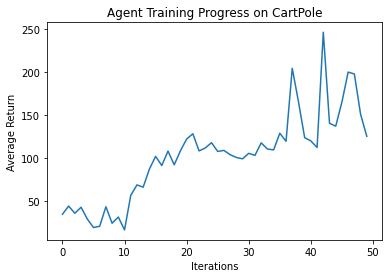

[34.8,
 44.4,
 36.0,
 43.0,
 29.4,
 19.4,
 20.8,
 43.6,
 24.4,
 31.6,
 16.6,
 56.8,
 69.0,
 66.4,
 87.4,
 102.2,
 91.6,
 108.4,
 92.4,
 108.8,
 122.4,
 128.6,
 108.6,
 112.0,
 118.2,
 108.0,
 109.2,
 104.2,
 101.0,
 99.4,
 105.8,
 103.4,
 118.0,
 110.8,
 109.8,
 129.2,
 119.8,
 204.8,
 166.0,
 124.0,
 120.2,
 112.6,
 246.8,
 140.8,
 137.4,
 165.6,
 200.4,
 198.2,
 151.4,
 125.6]

In [27]:
ray.shutdown()
ray.init()
ModelCatalog.register_custom_model("dqn_model", DQNCustomModel)
tf.random.set_seed(seed=0)
random.seed(0)
agent = DQN(env=CartPoleEnv, config={
    'env_config': {'verbose': False},
    'model': {
        'custom_model': 'dqn_model',
        'custom_model_config': {}
    },
    'replay_buffer_config' : {
        "type": 'MultiAgentPrioritizedReplayBuffer',
        "capacity": 50000,
        'prioritized_replay': True,
        'prioritized_replay_alpha': 0.6,
        'prioritized_replay_beta': 0.4,
        'prioritized_replay_eps': 1e-6,
        'replay_sequence_length': 1,
    },
    'num_steps_sampled_before_learning_starts': 5000,
    'target_network_update_freq': 2500,
    'rollout_fragment_length': 4,
    'train_batch_size': 64,
    'n_step': 3,
    'double_q': True,
    'dueling': True,
    'noisy': True,
    'num_atoms': 51,
    'v_min': -500.0,
    'v_max': 500.0,
    'exploration_config': {
        'epsilon_timesteps': 2,
        'final_epsilon': 0.0
    },
    'seed': 0,
    'gamma': 0.99,
    'lr': 0.001,
    'num_gpus': 1
})
agent.get_policy().model.base_model.summary(expand_nested=True)
utils.train(agent=agent, eval_env=CartPoleEnv(env_config={'verbose': False}))